In [1]:
import pandas as pd
import numpy as np
from BTC_Alpha_func import *
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
def single_factor_backtest(fac, ret, thresh=10, freq=5):
    all_dates = fac.index.get_level_values(0).unique()
    all_returns = [0]
    long_ = []
    short_ = []
    for date in tqdm(all_dates[::freq]):
        this_date_factor = fac.loc[date]
        this_date_retrun = ret.loc[date]
        long_thresh = np.percentile(this_date_factor, 100-thresh)
        short_thresh = np.percentile(this_date_factor, thresh)
        long_return = np.mean(this_date_retrun[this_date_factor > long_thresh]).values[0]
        short_return = np.mean(this_date_retrun[this_date_factor < short_thresh]).values[0]
#         if short_return < -1:
#             short_return = -1
#         if long_return < -1:
#             long_return = -1
        all_returns.append(long_return - short_return)
        long_.append(long_return)
        short_.append(short_return)
    all_returns = np.array(all_returns)

    return np.nan_to_num(all_returns), np.nan_to_num(long_), np.nan_to_num(short_), all_dates[::freq]

def performance(capitals, dates):
    plt.figure(figsize=(14,7))
    capital_list = np.cumsum(capitals)
    plt.plot(pd.Series(capital_list[1:],index = dates))
    return ret_ratio(capital_list), sharpe_ratio(capital_list), max_dd(capital_list)
    
def ret_ratio(capital_list):
    r=((capital_list[-1] - capital_list[0]) / capital_list[0])**(250/len(capital_list))-1
    return r

def sharpe_ratio(capital_list):
    return ret_ratio(capital_list) / (np.std(capital_list)*np.sqrt(250))
    
def max_dd(capital_list):
    i = np.argmax((np.maximum.accumulate(capital_list) - capital_list) / np.maximum.accumulate(capital_list)) # 结束位置 
    if i == 0: return 0
    j = np.argmax(capital_list[:i]) # 开始位置
    return (capital_list[j] - capital_list[i]) / (capital_list[j])

In [52]:
final_data = pd.read_parquet('v2.parquet')
ret = final_data[['adj_close']].groupby('stock').apply(lambda x:(DELAY(x,-5)/x-1).fillna(0))

In [70]:
def vol_adv20(data):
    return data['adj_volume'].groupby('stock').apply(lambda x:x/SUM(x, 20))

def vol_open_close(data):
    fac = (data['adj_volume'] / (data['adj_open'] - data['adj_close']))
    return fac.groupby('stock').apply(lambda x:EWM(x/SUM(x,20),20))

def prc_momentum(data):
    # 20-day-return
    fac = data.groupby('stock')['adj_close'].apply(lambda x: x/DELAY(x, 20))
    return fac

def abs_ret_sum(data):
    # 20-abs-return-sum
    ret = data.groupby('stock')['adj_close'].apply(lambda x:x/DELAY(x, 1)-1)
    fac = ret.groupby('stock').apply(lambda x: SUM(ABS(x),20))
    return fac   

def neg_close(data):
    return -data['adj_close']




def short_debt_equity(data):
    #3051/3501
    fac = (data['ITEM3051'] / data['ITEM3501'])
    return fac

def sales_asset(data):
    #18198/2201
    #EBITDA/ASSET
    fac = (data['ITEM18198'] / data['ITEM2201'])
    return fac


100%|███████████████████████████████████████████████████████████████████████████████| 680/680 [00:03<00:00, 207.68it/s]
C:\Users\Shawn Z\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Shawn Z\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


(inf, inf, 0)

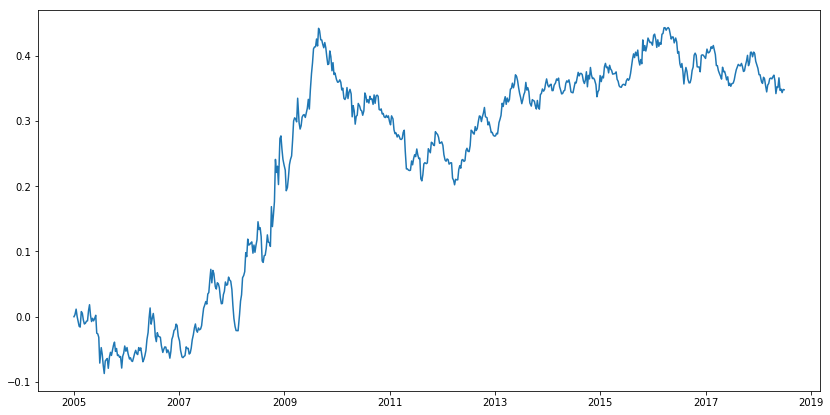

In [81]:
#neg_close(final_data)
capital, long, short, dates = single_factor_backtest(vol_adv20(final_data), ret, thresh=10, freq=5)
performance(capital, dates)

In [60]:
final_data.index.get_level_values(0).unique()
capital.shape

(681,)